In [1]:
%load_ext watermark
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np

from hierarchical_bayes_nmr_validation import *

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
protein1 = "1UBQ"
protein2 = '1D3Z'
bmrb_code = '6457'
marker = 'x'
samples = 2000

In [4]:
dataframe_ubq = get_biomolecular_data(protein1, bmrb_code)
dataframe_d3z = get_biomolecular_data(protein2, bmrb_code)

C:\Users\User\Documents\Agustina\Hierarchical-Bayes-NMR-Validation\cheshift\_cheshift.py:661: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)
C:\Users\User\Documents\Agustina\Hierarchical-Bayes-NMR-Validation\cheshift\_cheshift.py:661: RuntimeWarning: Mean of empty slice
  cs_theo_ave = np.nanmean(cs_theo_array, axis=0)


In [5]:
dataframe_ubq, trace_ubq, pps_ubq = hierarchical_reg_target(dataframe_ubq, samples=2000)
dataframe_d3z, trace_d3z, pps_d3z= hierarchical_reg_target(dataframe_d3z, samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α, beta_sd, alpha_sd]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
NUTS: [σ, β, α, beta_sd, alpha_sd]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, α, beta_sd, alpha_sd]
Could not pickle model, sampling singlethreaded.
Sequential sampling (4 chains in 1 job)
NUTS: [σ, β, α, beta_sd, alpha_sd]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 54 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.


# LOO

In [6]:
_, _, reference_dataframe = load_data()
mean_teo = reference_dataframe["ca_teo"].mean()
mean_exp = reference_dataframe["ca_exp"].mean()
std_teo = reference_dataframe["ca_teo"].std()
std_exp = reference_dataframe["ca_exp"].std()

In [7]:
idata_ubq = az.from_pymc3(trace_ubq, posterior_predictive={"cheshift":pps_ubq})
idata_ubq.observed_data['cheshift'] = idata_ubq.observed_data['cheshift'] * std_exp + mean_exp

c:\users\user\documents\agustina\arviz\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [8]:
idata_d3z = az.from_pymc3(trace_d3z, posterior_predictive={"cheshift":pps_d3z})
idata_d3z.observed_data['cheshift'] = idata_d3z.observed_data['cheshift'] * std_exp + mean_exp

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


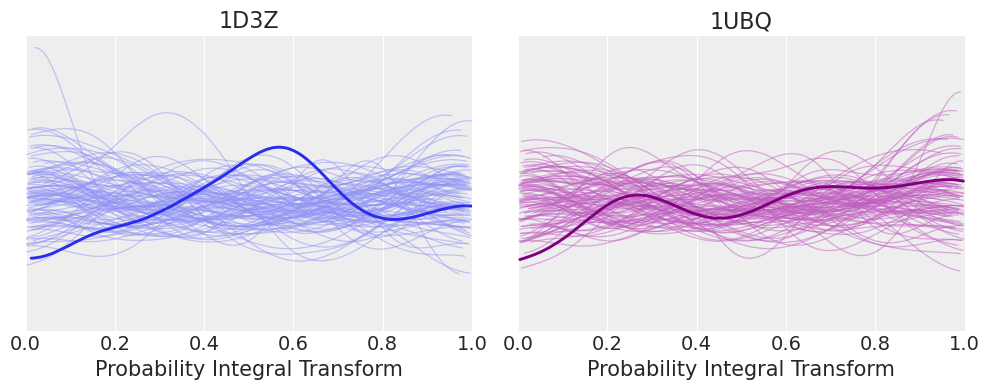

In [9]:
fig_, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_loo_pit(idata_d3z, y="cheshift", legend=False, ax=ax[0])
az.plot_loo_pit(idata_ubq, y="cheshift", legend=False, ax=ax[1], color='purple')
ax[0].set_title(protein2)
ax[1].set_title(protein1)
[ax[i].set_yticks([]) for i in range(len(ax))]
[ax[i].set_xlabel("Probability Integral Transform") for i in range(len(ax))]
plt.tight_layout()
plt.savefig(f"images/{protein1}_{protein2}_loo_pit.png")

# Khat

In [10]:
loo_ubq = az.loo(trace_ubq, pointwise=True)
loo_d3z = az.loo(trace_d3z, pointwise=True)

c:\users\user\documents\agustina\arviz\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
c:\users\user\documents\agustina\arviz\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
c:\users\user\documents\agustina\arviz\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. 

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


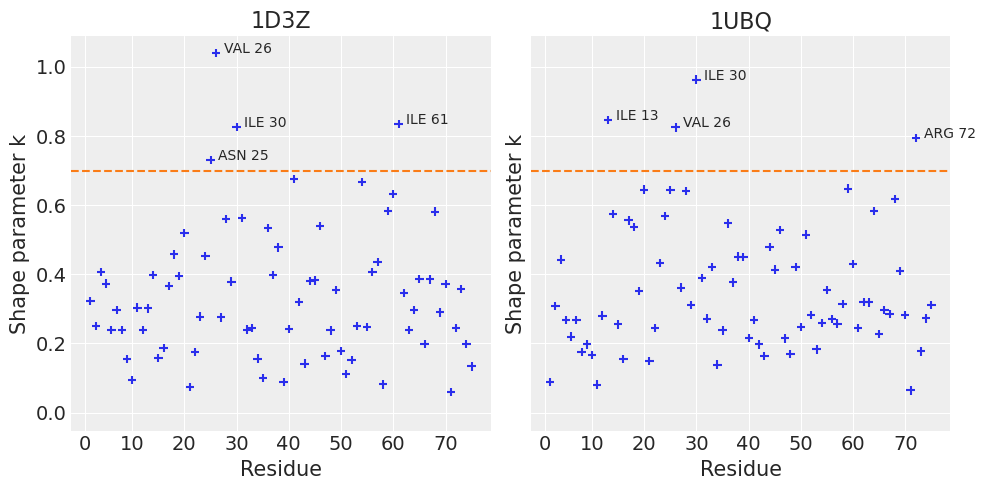

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

az.plot_khat(loo_d3z, hlines_kwargs={"alpha":0}, ax=ax[0])
az.plot_khat(loo_ubq, hlines_kwargs={"alpha":0}, ax=ax[1])

da_d3z = dataframe_d3z.res[loo_d3z.pareto_k.values > 0.7]
xs_d3z = da_d3z.index.values + 1
text_d3z = [a + " " + str(b) for a, b in zip(da_d3z, xs_d3z)]
ys_d3z = loo_d3z.pareto_k[loo_d3z.pareto_k > 0.7].values

for tx, x, y in zip(text_d3z, xs_d3z, ys_d3z):
    ax[0].annotate(tx, (x + 0.5 - dataframe_d3z.index[0], y))
    
da_ubq = dataframe_ubq.res[loo_ubq.pareto_k.values > 0.7]
xs_ubq = da_ubq.index.values +1
text_ubq = [a + " " + str(b) for a, b in zip(da_ubq, xs_ubq)]
ys_ubq = loo_ubq.pareto_k[loo_ubq.pareto_k > 0.7].values

for tx, x, y in zip(text_ubq, xs_ubq, ys_ubq):
    ax[1].annotate(tx, (x + 0.5 - dataframe_ubq.index[0], y))

[ax[i].axhline(0.7, color='C1', ls='--') for i in range(len(ax))]
    
[ax[i].set_xticks([-1, 8, 18, 28, 38, 48, 58, 68]) for i in range(len(ax))]
[ax[i].set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70']) for i in range(len(ax))]

[ax[i].set_title(protein) for i, protein in enumerate([protein2, protein1])]
[ax[i].set_xlabel('Residue') for i in range(len(ax))]

plt.tight_layout()

plt.savefig(f"images/{protein1}_{protein2}_khat.png")

# ELPD

In [12]:
loo_ubq = az.loo(trace_ubq, pointwise=True).loo_i.values
loo_d3z = az.loo(trace_d3z, pointwise=True).loo_i.values
elpd = loo_d3z - loo_ubq

c:\users\user\documents\agustina\arviz\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
c:\users\user\documents\agustina\arviz\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
c:\users\user\documents\agustina\arviz\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. 

c:\users\user\documents\agustina\arviz\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
c:\users\user\documents\agustina\arviz\arviz\stats\stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distrib

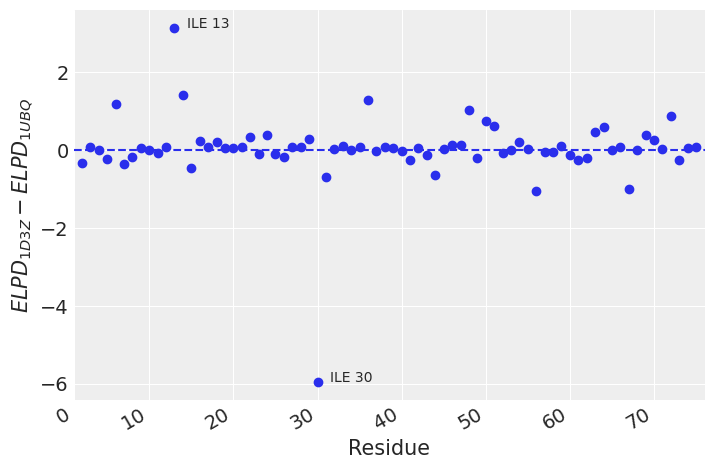

In [13]:
ax = az.plot_elpd({"1D3Z": idata_d3z, "1UBQ": idata_ubq}, xlabels=True)
ax.axhline(0, 0, 74, linestyle='dashed')
ax.set_xlabel('Residue')
ax.set_ylabel('$ELPD_{1D3Z}-ELPD_{1UBQ}$')
ax.set_xlim(1, len(dataframe_ubq))
ax.set_xticks([-1, 8, 18, 28, 38, 48, 58, 68])
ax.set_xticklabels(['0', '10', '20', '30', '40', '50', '60', '70'])
ax.set_title('')
da_ubq_1 = dataframe_ubq.res[elpd > 2]
da_ubq_2 = dataframe_ubq.res[elpd < -2]
da_ubq = pd.concat([da_ubq_1, da_ubq_2])
xs_ubq = da_ubq.index.values+1
text_ubq = [a + " " + str(b) for a, b in zip(da_ubq, xs_ubq)]
ys_ubq = np.concatenate([elpd[elpd > 2], elpd[elpd < -2]])

for tx, x, y in zip(text_ubq, xs_ubq, ys_ubq):
    ax.annotate(tx, (x + 0.5 - dataframe_ubq.index[0], y) )

plt.savefig(f'images/{protein1}_{protein2}_ELPD.png', bbox_inches="tight");

In [14]:
%watermark -v -m -p numpy,matplotlib,pymc3,arviz

CPython 3.7.7
IPython 7.18.1

numpy 1.18.5
matplotlib 3.3.1
pymc3 3.9.3
arviz 0.9.0
pymol 2.4.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores  : 8
interpreter: 64bit
